# Files selection

In [17]:
from astropy.io import fits
from dateutil import parser
from glob import glob
from collections import defaultdict

files = glob("/Users/lgarcia/code/pysnack10-prose/light_data/*.fits")
files_meta = defaultdict(dict)
observations = defaultdict(lambda: defaultdict(int))

for file in files:
    header = fits.getheader(file)
    files_meta[file]["date"] = parser.parse(header["DATE-OBS"])
    files_meta[file]["type"] = header["IMAGETYP"]
    observations[files_meta[file]["date"].date()][files_meta[file]["type"]] += 1

for date, obs in observations.items():
    print(date, f"\n{'-'*len(str(date))}")
    for obs_type, count in obs.items():
        print(f"{obs_type}: {count}")

2015-09-17 
----------
LIGHT: 163
FLAT: 30
DARK: 52
BIAS: 11


In [2]:
lights = list(filter(lambda f: files_meta[f]["type"] == "LIGHT", files))
lights = sorted(lights, key=lambda f: files_meta[f]["date"])
observation_date = files_meta[list(lights)[0]]["date"].date()


def filter_files(files, file_type):
    return list(
        filter(
            lambda f: files_meta[f]["type"] == file_type
            and files_meta[f]["date"].date() == observation_date,
            files,
        )
    )


biases = filter_files(files, "BIAS")
darks = filter_files(files, "DARK")
flats = filter_files(files, "FLAT")

## Reference image

In [3]:
from eloy import calibration

bias = calibration.master_bias(files=biases)
dark = calibration.master_dark(files=darks, bias=bias)
flat = calibration.master_flat(files=flats, bias=bias, dark=dark)

In [4]:
import numpy as np
from eloy import psf, detection, utils

trim = 50
n_stars_align = 12


def calibration_sequence(file):
    # getting data
    data = fits.getdata(file)
    header = fits.getheader(file)
    exposure = header["EXPTIME"]

    # calibration
    calibrated_data = calibration.calibrate(data, exposure, dark, flat, bias)
    # trimming
    calibrated_data = calibrated_data[trim:-trim, trim:-trim]
    # detection
    regions = detection.stars_detection(calibrated_data)
    # stars coords and cutouts
    region_coords = np.array([(r.centroid[1], r.centroid[0]) for r in regions])
    cutouts = utils.cutout(calibrated_data, region_coords, (50, 50))

    # epsf modeling
    cutouts_normalized = cutouts / np.nanmax(cutouts, (1, 2))[:, None, None]
    epsf = np.nanmedian(cutouts_normalized, 0)
    psf_params = psf.fit_gaussian(epsf)
    fwhm = psf.gaussian_sigma_to_fwhm * np.mean(
        [psf_params["sigma_x"], psf_params["sigma_y"]]
    )

    del (
        cutouts_normalized,
        data,
        regions,
        cutouts,
        epsf,
        header,
    )

    return calibrated_data, region_coords, fwhm

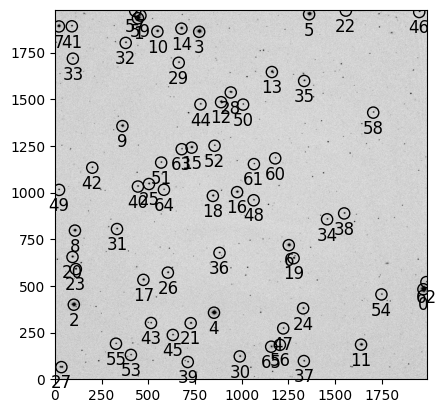

In [5]:
import matplotlib.pyplot as plt
from eloy import alignment, viz

# reference
reference_file = lights[len(lights) // 2]
ref_data, ref_coords, ref_fwhm = calibration_sequence(reference_file)
ref_reference = alignment.twirl_reference(ref_coords[0:n_stars_align])

plt.imshow(viz.z_scale(ref_data), cmap="Greys", origin="lower")
viz.plot_marks(*ref_coords.T, color="k", label=True, ms=30)

## Photometry

In [6]:
from tqdm.autonotebook import tqdm
from skimage.transform import AffineTransform
from eloy import centroid, photometry

n_stars = 20
cutout_shape = (21, 21)
relative_apertures_radii = np.linspace(0.1, 5, 40)

data = defaultdict(list)

for file in tqdm(lights):
    calibrated_data, coords, fwhm = calibration_sequence(file)

    # alignment
    R = alignment.rotation_matrix(coords[0:n_stars_align], ref_coords, ref_reference)
    transform = AffineTransform(R).inverse
    aligned_coords = transform(ref_coords)[0:n_stars]
    dx, dy = np.median(ref_coords[0:n_stars] - aligned_coords, 0)

    # centroiding
    centroid_coords = centroid.photutils_centroid(
        calibrated_data, aligned_coords, centroid_fun=centroid.centroid_quadratic
    )
    # aperture photometry
    apertures_radii = relative_apertures_radii * fwhm
    flux = photometry.aperture_photometry(
        calibrated_data, centroid_coords, apertures_radii
    )
    # annulus background correction
    annulus_radii = np.max(apertures_radii), 8 * fwhm
    aperture_area = np.pi * apertures_radii**2
    bkg = photometry.annulus_sigma_clip_median(
        calibrated_data, centroid_coords, *annulus_radii
    )
    bkg = bkg[:, None] * aperture_area[None, :]

    # getting data
    header = fits.open(file)[0].header
    data["bkg"].append(bkg)
    data["fluxes"].append(flux)
    data["fwhm"].append(fwhm)
    data["time"].append(header["JD"])
    data["dx"].append(dx)
    data["dy"].append(dy)


for k, v in data.items():
    data[k] = np.array(v)

/var/folders/q0/m16jxqmd1zj3rhbhwkklywk40000gq/T/ipykernel_59491/4277059863.py:1: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
100%|██████████| 163/163 [00:45<00:00,  3.58it/s]


## Differential light curve

In [11]:
from eloy import flux

target = 16
fluxes = (data["fluxes"] - data["bkg"]).T
diffs, weights = flux.auto_diff(fluxes, target)
best_aperture = flux.optimal_flux(diffs[:, target])
diff = diffs[best_aperture, target]

<ErrorbarContainer object of 3 artists>

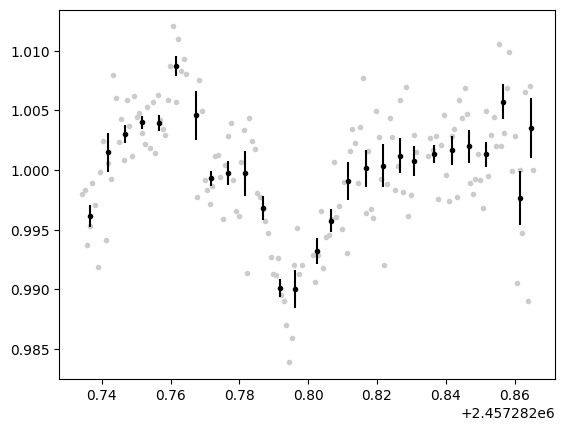

In [12]:
idxs = utils.index_binning(data["time"], 0.005)
binned_time = [data["time"][i].mean() for i in idxs]
binned_diff = [diff[i].mean() for i in idxs]
binned_error = [diff[i].std() / np.sqrt(len(i)) for i in idxs]

plt.plot(data["time"], diffs[best_aperture, target, :], ".", c="0.8")
plt.errorbar(binned_time, binned_diff, yerr=binned_error, fmt=".", c="k")